# Comparison of CMIP6 s2p3 runs over GBR

In [9]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
import os


## notes

I've manually regridded (cdo remapbil,r360x180) ACCESS-CM2 becaus uas and va had different numbers of latitudes. This is not ideal, so keep in mind

*general stuff the script needs*

In [10]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

def compariable_across_grids(cube1,cube2,lon_west,lon_east,lat_south,lat_north):
    cube1_region = extract_region(cube1,lon_west,lon_east,lat_south,lat_north)
    cube2_region = extract_region(cube2,lon_west,lon_east,lat_south,lat_north)
    
    cube2_region.coord('latitude').coord_system = cube1_region.coord('latitude').coord_system
    cube2_region.coord('longitude').coord_system =cube1_region.coord('longitude').coord_system

    cube1_region_regridded = cube1_region.regrid(cube2_region, iris.analysis.Linear())
    cube2_region.data.mask = cube1_region_regridded.data.mask


    cube2_region.data[np.where(cube2_region.data < -20.0)] = cube2_region.data.fill_value
    cube2_region.data[np.where(cube2_region.data >100.0)] = cube2_region.data.fill_value
    cube2_region.data = np.ma.masked_where(cube2_region.data == cube2_region.data.fill_value, cube2_region.data)

    cube1_region_regridded.data[np.where(cube1_region_regridded.data < -20.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data[np.where(cube1_region_regridded.data > 100.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data = np.ma.masked_where(cube1_region_regridded.data == cube1_region_regridded.data.fill_value, cube1_region_regridded.data)
    return cube1_region_regridded,cube2_region


def select_year_range(cube, my_range):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube[np.where((cube.coord('year').points > my_range[0]) & (cube.coord('year').points < my_range[1]))]


#note, they shoudl already be on the same grid and the same region
def anomaly_fields_from_satellite(model_cube,satilite_cube,common_yr_start,common_yr_end):
    model_cube_climatology = select_year_range(model_cube, [common_yr_start,common_yr_end]).collapsed('time',iris.analysis.MEAN)
    satilite_cube_climatology = select_year_range(satilite_cube, [common_yr_start,common_yr_end]).collapsed('time',iris.analysis.MEAN)
    diff = model_cube_climatology.copy()
    diff.data = model_cube_climatology.data - satilite_cube_climatology.data
    return model_cube - diff
    
    

    



load model data

In [11]:
directory = '/Users/ph290/Downloads/s2p3_cmip6/'

models = ['CanESM5','MRI-ESM2-0','EC-Earth3-Veg']
experiments = ['ssp585','ssp119']
variables = ['surfacetemperature']

model_cubes = {}
for model in models:
    model_cubes[model] = {}
    for experiment in experiments:
        model_cubes[model][experiment] = {}
        for variable in variables:
            if os.path.exists(directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc'):
                model_cubes[model][experiment][variable] = {}
                cube_tmp = iris.load_cube(directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc')
                try:
                    iris.coord_categorisation.add_year(cube_tmp, 'time', name='year')
                except:
                    pass
                cube_tmp.data = np.ma.masked_where(cube_tmp.data == 9.96920997e+36, cube_tmp.data)
                model_cubes[model][experiment][variable]['RawModel'] = cube_tmp
            else:
                print 'file does not exist: ',directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc'


load observational data

In [12]:

obs_cube_all = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_year_mean.nc','sea_surface_temperature')
try:
    iris.coord_categorisation.add_year(obs_cube_all, 'time', name='year')
except:
    pass


lon_west,lon_east,lat_south,lat_north = 142,156,-29,-10
obs_cube_all_region = extract_region(obs_cube_all,lon_west,lon_east,lat_south,lat_north)

## GBR timeseries comparison model v. CRW

In [13]:
for model in models:
    for experiment in experiments:
        for variable in variables:
            if os.path.exists(directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc'):
                tmp = compariable_across_grids(model_cubes[model][experiment][variable]['RawModel'],obs_cube_all,142,156,-29,-10)
                model_cubes[model][experiment][variable]['ModelOnSatGrid'] = tmp[0]
                model_cubes[model][experiment][variable]['SatWithModelMask'] = tmp[1]
            
# model_region_regridded,obs_region = compariable_across_grids(cube_all,obs_cube_all,142,156,-29,-10)
# model_bottom_region_regridded,obs_region = compariable_across_grids(cube_all_bottom,obs_cube_all,142,156,-29,-10)


## Multi model SST CRW corrected

In [14]:
# corrected_model_field = anomaly_fields_from_satellite(model_region_regridded,obs_region,1995,2015)

for model in models:
    for experiment in experiments:
        if os.path.exists(directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc'):
            variable = 'surfacetemperature'
            model_cubes[model][experiment][variable]['ModelCorrectedToCRW'] = anomaly_fields_from_satellite(model_cubes[model][experiment][variable]['ModelOnSatGrid'],obs_cube_all_region,1995,2015)




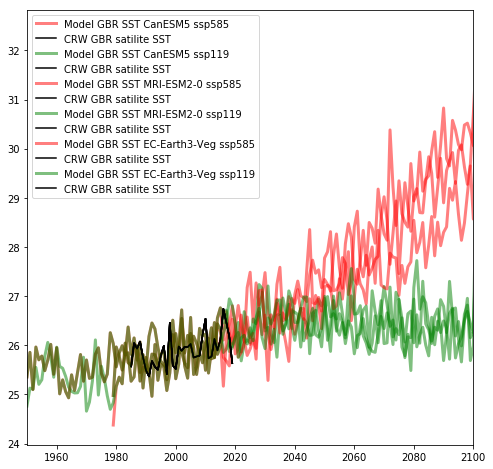

In [15]:
import scipy
import matplotlib.pyplot as plt
from scipy import signal

plotting_range = [1950,2100]

fig, ax1 = plt.subplots(figsize=(8, 8))


variable = 'surfacetemperature'

for model in models:
    for experiment in experiments:
        if os.path.exists(directory+model+'_GBR_'+variable+'_hist'+experiment+'_ym.nc'):
            if experiment == 'ssp585':
                plt_color = 'r'

            if experiment == 'ssp119':
                plt_color = 'g'
            cube_all_region_area_avg = area_avg(model_cubes[model][experiment][variable]['ModelCorrectedToCRW'])
            obs_cube_all_region_area_avg = area_avg(model_cubes[model][experiment][variable]['SatWithModelMask'])

            ax1.plot(cube_all_region_area_avg.coord('year').points,cube_all_region_area_avg.data,plt_color,label='Model GBR SST '+model+' '+experiment,alpha=0.5,lw=3)
            ax1.plot(obs_cube_all_region_area_avg.coord('year').points,obs_cube_all_region_area_avg.data,'k',label='CRW GBR satilite SST')
    #         ax1.plot(cube_all_region_area_avg_bottom.coord('year').points,cube_all_region_area_avg_bottom.data,'g',label='Model GBR bottom temperature')


ax1.set_xlim(plotting_range)
plt.legend()
plt.show()






*thoughts:* is the model drifting to the right temperature after a long spinup stage? Start the run earlier and/or change the initialisation temperature and re-run.

In [ ]:
Do DHW

In [ ]:
Do spot comparison with moorings

In [16]:
Note that IPSL does not have HURS and trying to take HUR and teh lowest level dfoes not work  ecause there are gaps at that pressure level...

SyntaxError: invalid syntax (<ipython-input-16-2ec53a756640>, line 1)